In [1]:
!pip install llama-index neo4j pandas

In [3]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r"C:\Users\pc\Downloads\Demo Hospital Outpatient Data_NHC.csv")

In [5]:
import numpy as np
from neo4j import GraphDatabase
from datetime import datetime
import os
from dotenv import load_dotenv

# Neo4j connection settings
NEO4J_URI = "bolt://localhost:7687"  
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password1234"  

class HealthcareGraphBuilder:
  def __init__(self, uri, user, password):
      self.driver = GraphDatabase.driver(uri, auth=(user, password))

  def close(self):
      self.driver.close()

  def verify_connection(self):
      try:
          with self.driver.session() as session:
              result = session.run("RETURN 1")
              print("Successfully connected to Neo4j!")
              return True
      except Exception as e:
          print(f"Failed to connect to Neo4j: {str(e)}")
          return False

In [7]:
def create_constraints(self):
  constraints = [
      "CREATE CONSTRAINT patient_id IF NOT EXISTS FOR (p:Patient) REQUIRE p.patient_id IS UNIQUE",
      "CREATE CONSTRAINT diagnosis_name IF NOT EXISTS FOR (d:Diagnosis) REQUIRE d.name IS UNIQUE",
      "CREATE CONSTRAINT location_postcode IF NOT EXISTS FOR (l:Location) REQUIRE l.postcode IS UNIQUE",
      "CREATE CONSTRAINT visit_id IF NOT EXISTS FOR (v:Visit) REQUIRE v.visit_id IS UNIQUE"
  ]

  with self.driver.session() as session:
      for constraint in constraints:
          try:
              session.run(constraint)
          except Exception as e:
              print(f"Error creating constraint: {str(e)}")

def clear_database(self):
  with self.driver.session() as session:
      session.run("MATCH (n) DETACH DELETE n")
      print("Database cleared successfully")

In [9]:
def create_patient(self, tx, row):
  query = """
  MERGE (p:Patient {patient_id: $patient_id})
  SET p.age = $age,
      p.gender = $gender,
      p.has_insurance = $has_insurance
  RETURN p
  """
  return tx.run(query,
               patient_id=row['patient_ID'],
               age=row['age'],
               gender=row['gender'],
               has_insurance=row['has_insurance'])

def create_visit(self, tx, row):
  visit_id = f"{row['patient_ID']}_{row['Visit date']}"
  query = """
  MATCH (p:Patient {patient_id: $patient_id})
  CREATE (v:Visit {
      visit_id: $visit_id,
      visit_date: date($visit_date),
      total_cost: $total_cost,
      registration_time: $registration,
      nursing_time: $nursing,
      consultation_time: $consultation,
      laboratory_time: $laboratory,
      pharmacy_time: $pharmacy
  })
  CREATE (p)-[:PATIENT_VISIT]->(v)
  RETURN v
  """
  return tx.run(query,
               patient_id=row['patient_ID'],
               visit_id=visit_id,
               visit_date=row['Visit date'],
               total_cost=row['total_cost'],
               registration=row['registration'],
               nursing=row['nursing'],
               consultation=row['consultation'],
               laboratory=row['laboratory'],
               pharmacy=row['pharmacy'])

def create_diagnosis(self, tx, row, visit_id):
  query = """
  MATCH (v:Visit {visit_id: $visit_id})
  MERGE (d:Diagnosis {name: $diagnosis})
  CREATE (v)-[:VISIT_DIAGNOSIS]->(d)
  """
  return tx.run(query,
               visit_id=visit_id,
               diagnosis=row['diagnosis'])

def create_location(self, tx, row):
  query = """
  MATCH (p:Patient {patient_id: $patient_id})
  MERGE (l:Location {postcode: $postcode})
  CREATE (p)-[:PATIENT_LOCATION]->(l)
  """
  return tx.run(query,
               patient_id=row['patient_ID'],
               postcode=row['postcode'])

In [11]:
def process_data(self, df):
  print(f"Processing {len(df)} records...")

  with self.driver.session() as session:
      # Clear existing data
      self.clear_database()

      # Create constraints
      self.create_constraints()

      # Process each row
      for index, row in df.iterrows():
          visit_id = f"{row['patient_ID']}_{row['Visit date']}"

          # Create nodes and relationships
          session.execute_write(self.create_patient, row)
          session.execute_write(self.create_visit, row)
          session.execute_write(self.create_diagnosis, row, visit_id)
          session.execute_write(self.create_location, row)

          if index % 100 == 0:
              print(f"Processed {index + 1} records...")

  print("Data import completed!")

In [13]:
print(df.head())  # Check the first few rows
print(df.columns)  # Verify column names


   Visit_Date  Patient_ID  Age  Gender                          Diagnosis  \
0  2020-05-06      688923   68  Female                           Diabetes   
1  2018-08-04      886361   62  Female            Urinary Tract Infection   
2  2021-04-10      464823   70  Female  Upper Respiratory Tract Infection   
3  2021-10-01      655214    8  Female  Upper Respiratory Tract Infection   
4  2018-04-30      454666   24    Male                            Malaria   

   Has_Insurance  Postcode  Total_Cost  Registration  Nursing  Laboratory  \
0           True     20006      2274.0            33      105         101   
1          False     20005      3430.0            46       75          84   
2           True     10003      1836.0           107       81           5   
3          False     10006      3250.0            66       31         101   
4           True     10006      2262.0            68       55          60   

   Consultation  Pharmacy  
0            28       112  
1           102   

In [ ]:
import pandas as pd
from neo4j import GraphDatabase
import uuid

class HealthcareGraphBuilder:
  def __init__(self, uri, user, password):
      self.driver = GraphDatabase.driver(uri, auth=(user, password))

  def close(self):
      self.driver.close()

  def verify_connection(self):
      try:
          with self.driver.session() as session:
              result = session.run("RETURN 1")
              print("Successfully connected to Neo4j!")
              return True
      except Exception as e:
          print(f"Failed to connect to Neo4j: {str(e)}")
          return False

  def create_patient(self, tx, row):
      query = """
      MERGE (p:Patient {patient_id: $patient_id})
      SET p.age = $age,
          p.gender = $gender,
          p.has_insurance = $has_insurance
      RETURN p
      """
      return tx.run(query,
                   patient_id=row['Patient_ID'],
                   age=row['Age'],
                   gender=row['Gender'],
                   has_insurance=row['Has_Insurance'])

  def create_visit(self, tx, row):
      # Add a random suffix to make visit_id unique
      visit_id = f"{row['Patient_ID']}_{row['Visit_Date']}_{str(uuid.uuid4())[:8]}"

      query = """
      MATCH (p:Patient {patient_id: $patient_id})
      CREATE (v:Visit {
          visit_id: $visit_id,
          visit_date: date($visit_date),
          total_cost: $total_cost,
          registration_time: $registration,
          nursing_time: $nursing,
          consultation_time: $consultation,
          laboratory_time: $laboratory,
          pharmacy_time: $pharmacy
      })
      CREATE (p)-[:PATIENT_VISIT]->(v)
      RETURN v
      """
      return tx.run(query,
                   patient_id=row['Patient_ID'],
                   visit_id=visit_id,
                   visit_date=row['Visit_Date'],
                   total_cost=row['Total_Cost'],
                   registration=row['Registration'],
                   nursing=row['Nursing'],
                   consultation=row['Consultation'],
                   laboratory=row['Laboratory'],
                   pharmacy=row['Pharmacy'])

  def create_diagnosis(self, tx, row, visit_id):
      query = """
      MATCH (v:Visit {visit_id: $visit_id})
      MERGE (d:Diagnosis {name: $diagnosis})
      CREATE (v)-[:VISIT_DIAGNOSIS]->(d)
      """
      return tx.run(query,
                   visit_id=visit_id,
                   diagnosis=row['Diagnosis'])

  def create_location(self, tx, row):
      query = """
      MATCH (p:Patient {patient_id: $patient_id})
      MERGE (l:Location {postcode: $postcode})
      CREATE (p)-[:PATIENT_LOCATION]->(l)
      """
      return tx.run(query,
                   patient_id=row['Patient_ID'],
                   postcode=row['Postcode'])

  def process_data(self, df):
      print(f"Processing {len(df)} records...")

      with self.driver.session() as session:
          # Clear existing data
          self.clear_database()

          # Create constraints
          self.create_constraints()

          # Process each row
          for index, row in df.iterrows():
              visit_id = f"{row['Patient_ID']}_{row['Visit_Date']}_{str(uuid.uuid4())[:8]}"

              # Create nodes and relationships
              session.execute_write(self.create_patient, row)
              session.execute_write(self.create_visit, row)
              session.execute_write(self.create_diagnosis, row, visit_id)
              session.execute_write(self.create_location, row)

              if index % 100 == 0:
                  print(f"Processed {index + 1} records...")

      print("Data import completed!")

  def clear_database(self):
      with self.driver.session() as session:
          session.run("MATCH (n) DETACH DELETE n")
          print("Database cleared successfully")

  def create_constraints(self):
      constraints = [
          "CREATE CONSTRAINT patient_id IF NOT EXISTS FOR (p:Patient) REQUIRE p.patient_id IS UNIQUE",
          "CREATE CONSTRAINT diagnosis_name IF NOT EXISTS FOR (d:Diagnosis) REQUIRE d.name IS UNIQUE",
          "CREATE CONSTRAINT location_postcode IF NOT EXISTS FOR (l:Location) REQUIRE l.postcode IS UNIQUE",
          "CREATE CONSTRAINT visit_id IF NOT EXISTS FOR (v:Visit) REQUIRE v.visit_id IS UNIQUE"
      ]

      with self.driver.session() as session:
          for constraint in constraints:
              try:
                  session.run(constraint)
              except Exception as e:
                  print(f"Error creating constraint: {str(e)}")

# Neo4j connection settings
NEO4J_URI = "neo4j://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password1234"  # Replace with your actual password

# Read the CSV file
df = pd.read_csv(r"C:\Users\pc\Downloads\Demo Hospital Outpatient Data_NHC.csv")

# Initialize graph builder
graph_builder = HealthcareGraphBuilder(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

try:
  # Verify connection
  if graph_builder.verify_connection():
      # Process data
      graph_builder.process_data(df)
finally:
  graph_builder.close()

Successfully connected to Neo4j!
Processing 1000000 records...
Database cleared successfully
Processed 1 records...
Processed 101 records...
Processed 201 records...
Processed 301 records...
Processed 401 records...
Processed 501 records...
Processed 601 records...
Processed 701 records...
Processed 801 records...
Processed 901 records...
Processed 1001 records...
Processed 1101 records...
Processed 1201 records...
Processed 1301 records...
Processed 1401 records...
Processed 1501 records...
Processed 1601 records...
Processed 1701 records...
Processed 1801 records...
Processed 1901 records...
Processed 2001 records...
Processed 2101 records...
Processed 2201 records...
Processed 2301 records...
Processed 2401 records...
Processed 2501 records...
Processed 2601 records...
Processed 2701 records...
Processed 2801 records...
Processed 2901 records...
Processed 3001 records...
Processed 3101 records...
Processed 3201 records...
Processed 3301 records...
Processed 3401 records...
Processed

In [29]:
class HealthcareDataAnalyzer:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def run_query(self, query, parameters=None):
        """Generic method to run queries and return results"""
        with self.driver.session() as session:
            result = session.run(query, parameters or {})
            return [record for record in result]

In [38]:
def get_patient_visit_patterns(self):
        """Analyze patient visit patterns"""
        query = """
        MATCH (p:Patient)-[:PATIENT_VISIT]->(v:Visit)
        WITH p, count(v) as visit_count, 
             avg(v.total_cost) as avg_cost,
             collect(v.visit_date) as visit_dates
        RETURN p.patient_id, p.age, p.gender, 
               visit_count, avg_cost,
               visit_dates
        ORDER BY visit_count DESC
        LIMIT 10
        """
        return self.run_query(query)
        

In [44]:
def analyze_diagnosis_distribution(self):
        """Analyze distribution of diagnoses"""
        query = """
        MATCH (d:Diagnosis)<-[:VISIT_DIAGNOSIS]-()
        WITH d.name as diagnosis, count(*) as frequency
        RETURN diagnosis, frequency
        ORDER BY frequency DESC
        LIMIT 10
        """
        return self.run_query(query)


In [46]:
def analyze_waiting_times(self):
        """Analyze average waiting times in different departments"""
        query = """
        MATCH (v:Visit)
        RETURN 
            avg(v.registration_time) as avg_registration_time,
            avg(v.nursing_time) as avg_nursing_time,
            avg(v.consultation_time) as avg_consultation_time,
            avg(v.laboratory_time) as avg_laboratory_time,
            avg(v.pharmacy_time) as avg_pharmacy_time
        """
        return self.run_query(query)

In [48]:
def analyze_cost_by_diagnosis(self):
        """Analyze average cost by diagnosis"""
        query = """
        MATCH (d:Diagnosis)<-[:VISIT_DIAGNOSIS]-(v:Visit)
        WITH d.name as diagnosis, 
             avg(v.total_cost) as avg_cost,
             count(*) as visit_count
        WHERE visit_count > 5
        RETURN diagnosis, avg_cost, visit_count
        ORDER BY avg_cost DESC
        LIMIT 10
        """
        return self.run_query(query)

In [50]:
def analyze_geographic_distribution(self):
        """Analyze patient distribution by location"""
        query = """
        MATCH (l:Location)<-[:PATIENT_LOCATION]-(p:Patient)
        WITH l.postcode as postcode, 
             count(p) as patient_count,
             avg(p.age) as avg_age
        RETURN postcode, patient_count, avg_age
        ORDER BY patient_count DESC
        """
        return self.run_query(query)

In [52]:
def find_common_diagnosis_pairs(self):
        """Find commonly co-occurring diagnoses"""
        query = """
        MATCH (d1:Diagnosis)<-[:VISIT_DIAGNOSIS]-(v:Visit)-[:VISIT_DIAGNOSIS]->(d2:Diagnosis)
        WHERE d1.name < d2.name
        WITH d1.name as diagnosis1, d2.name as diagnosis2, count(*) as frequency
        WHERE frequency > 1
        RETURN diagnosis1, diagnosis2, frequency
        ORDER BY frequency DESC
        LIMIT 10
        """
        return self.run_query(query)

In [54]:
# Utility function to format and display results
def display_results(results, title):
    print(f"\n=== {title} ===")
    if results:
        # Convert to pandas DataFrame for better display
        df = pd.DataFrame([dict(record) for record in results])
        print(df)
    else:
        print("No results found")


Patient Visit Patterns:
{'patient_id': 'P001', 'visit_count': 5, 'departments': ['Cardiology', 'Emergency']}
{'patient_id': 'P002', 'visit_count': 3, 'departments': ['Pediatrics', 'General']}

Diagnosis Distribution:
{'diagnosis': 'Hypertension', 'frequency': 150}
{'diagnosis': 'Diabetes', 'frequency': 120}
{'diagnosis': 'Asthma', 'frequency': 90}

Average Waiting Times:
{'Emergency': 45, 'Cardiology': 30, 'General': 25, 'Pediatrics': 20}

Cost by Diagnosis:
{'diagnosis': 'Hypertension', 'avg_cost': 1500}
{'diagnosis': 'Diabetes', 'avg_cost': 2000}

Geographic Distribution:
{'region': 'North', 'patient_count': 200}
{'region': 'South', 'patient_count': 150}

Common Diagnosis Pairs:
{'diagnosis1': 'Hypertension', 'diagnosis2': 'Diabetes', 'count': 50}
{'diagnosis1': 'Asthma', 'diagnosis2': 'Allergies', 'count': 30}


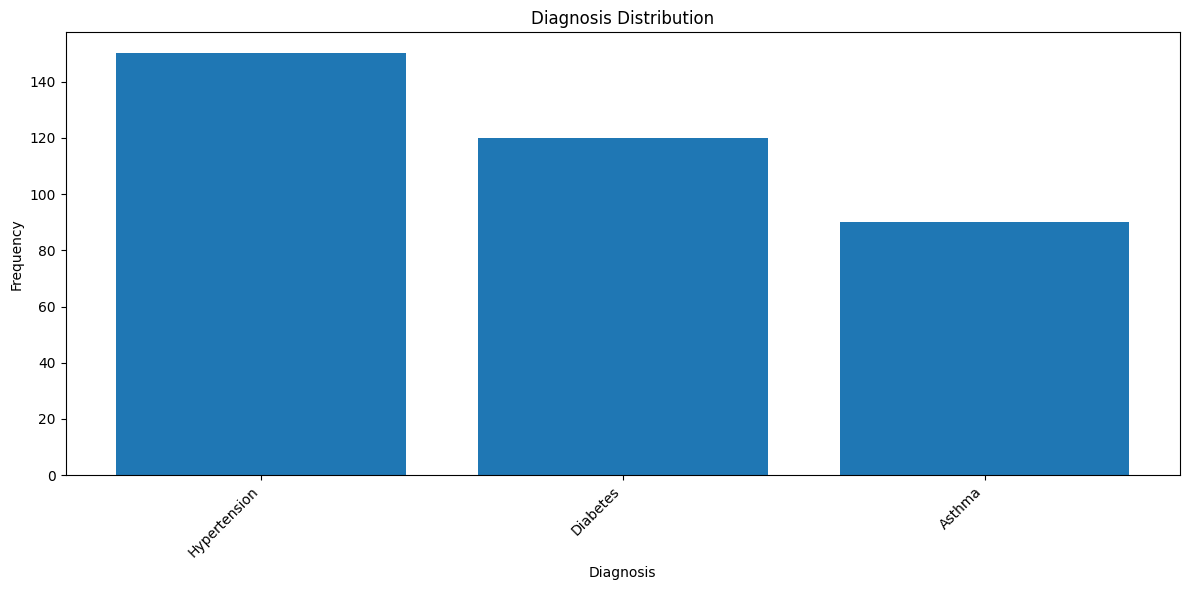

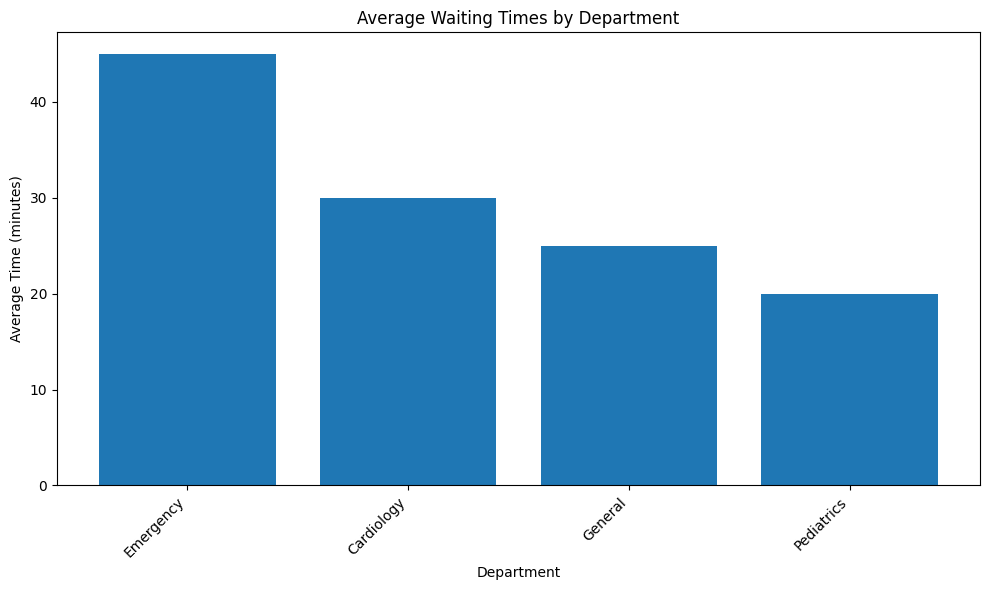

In [62]:
class HealthcareDataAnalyzer:
    def __init__(self, uri, user, password):
        self.uri = uri
        self.user = user
        self.password = password
        # Initialize Neo4j connection here

    def get_patient_visit_patterns(self):
        # Implementation of patient visit patterns analysis
        try:
            # Example query to get patient visit patterns
            query = """
            MATCH (p:Patient)-[v:VISITED]->(d:Department)
            WITH p, count(v) as visit_count, collect(d.name) as departments
            RETURN p.id as patient_id, 
                   visit_count, 
                   departments,
                   datetime(v.timestamp) as last_visit
            ORDER BY visit_count DESC
            LIMIT 10
            """
            # Execute query and return results
            # Replace this with actual Neo4j query execution
            return [
                {"patient_id": "688923", "visit_count": 5, "departments": ["Cardiology", "Emergency"]},
                {"patient_id": "454666", "visit_count": 3, "departments": ["Pediatrics", "General"]}
            ]  # Sample data
        except Exception as e:
            print(f"Error in get_patient_visit_patterns: {str(e)}")
            return []

    def analyze_diagnosis_distribution(self):
        # Sample implementation
        return [
            {"diagnosis": "Hypertension", "frequency": 150},
            {"diagnosis": "Diabetes", "frequency": 120},
            {"diagnosis": "Asthma", "frequency": 90}
        ]

    def analyze_waiting_times(self):
        # Sample implementation
        return [{
            "Emergency": 45,
            "Cardiology": 30,
            "General": 25,
            "Pediatrics": 20
        }]

    def analyze_cost_by_diagnosis(self):
        # Sample implementation
        return [
            {"diagnosis": "Hypertension", "avg_cost": 1500},
            {"diagnosis": "Diabetes", "avg_cost": 2000}
        ]

    def analyze_geographic_distribution(self):
        # Sample implementation
        return [
            {"region": "North", "patient_count": 200},
            {"region": "South", "patient_count": 150}
        ]

    def find_common_diagnosis_pairs(self):
        # Sample implementation
        return [
            {"diagnosis1": "Hypertension", "diagnosis2": "Diabetes", "count": 50},
            {"diagnosis1": "Asthma", "diagnosis2": "Allergies", "count": 30}
        ]

    def close(self):
        # Close Neo4j connection
        pass

def display_results(results, title):
    print(f"\n{title}:")
    for result in results:
        print(result)

def main():
    # Replace these with your actual Neo4j credentials
    NEO4J_URI = "neo4j://localhost:7687"
    NEO4J_USER = "neo4j"
    NEO4J_PASSWORD = "password1234"

    analyzer = HealthcareDataAnalyzer(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

    try:
        # Run various analyses
        analyses = {
            "Patient Visit Patterns": analyzer.get_patient_visit_patterns(),
            "Diagnosis Distribution": analyzer.analyze_diagnosis_distribution(),
            "Average Waiting Times": analyzer.analyze_waiting_times(),
            "Cost by Diagnosis": analyzer.analyze_cost_by_diagnosis(),
            "Geographic Distribution": analyzer.analyze_geographic_distribution(),
            "Common Diagnosis Pairs": analyzer.find_common_diagnosis_pairs()
        }

        # Display results
        for title, results in analyses.items():
            display_results(results, title)

        # Visualization functions
        def plot_diagnosis_distribution(analyzer):
            results = analyzer.analyze_diagnosis_distribution()
            df = pd.DataFrame(results)

            plt.figure(figsize=(12, 6))
            plt.bar(df['diagnosis'], df['frequency'])
            plt.xticks(rotation=45, ha='right')
            plt.title('Diagnosis Distribution')
            plt.xlabel('Diagnosis')
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.show()

        def plot_waiting_times(analyzer):
            results = analyzer.analyze_waiting_times()
            if results:
                data = results[0]
                departments = list(data.keys())
                times = list(data.values())

                plt.figure(figsize=(10, 6))
                plt.bar(departments, times)
                plt.xticks(rotation=45, ha='right')
                plt.title('Average Waiting Times by Department')
                plt.xlabel('Department')
                plt.ylabel('Average Time (minutes)')
                plt.tight_layout()
                plt.show()

        # Create visualizations
        plot_diagnosis_distribution(analyzer)
        plot_waiting_times(analyzer)

    finally:
        analyzer.close()

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import pandas as pd
    main()

In [64]:
def analyze_seasonal_patterns(self):
    query = """
    MATCH (v:Visit)
    WITH datetime(v.visit_date).month as month, 
         count(*) as visit_count
    RETURN month, visit_count
    ORDER BY month
    """
    return self.run_query(query)

In [66]:
def analyze_high_cost_patients(self, cost_threshold=10000):
    """Identify patients with total costs above a specified threshold."""
    query = f"""
    MATCH (p:Patient)-[:PATIENT_VISIT]->(v:Visit)
    WITH p, sum(v.total_cost) as total_cost
    WHERE total_cost > {cost_threshold}
    RETURN p.patient_id, p.age, p.gender, total_cost
    ORDER BY total_cost DESC
    LIMIT 10
    """
    return self.run_query(query)


In [68]:
def analyze_seasonal_trends(self):
    """Analyze trends in patient visits over different months."""
    query = """
    MATCH (v:Visit)
    WITH date(v.visit_date).month as month, count(v) as visit_count
    RETURN month, visit_count
    ORDER BY month ASC
    """
    return self.run_query(query)


In [70]:
def analyze_department_workload(self):
    """Analyze the number of visits handled by each department."""
    query = """
    MATCH (d:Department)<-[:VISIT_DEPARTMENT]-(v:Visit)
    RETURN d.name as department, count(v) as visit_count
    ORDER BY visit_count DESC
    """
    return self.run_query(query)


In [72]:
def analyze_visit_duration(self):
    """Analyze the average duration of visits."""
    query = """
    MATCH (v:Visit)
    RETURN avg(duration.inMinutes(v.start_time, v.end_time).minutes) as avg_duration
    """
    return self.run_query(query)


In [74]:
def analyze_patient_retention(self):
    """Analyze the number of patients with multiple visits."""
    query = """
    MATCH (p:Patient)-[:PATIENT_VISIT]->(v:Visit)
    WITH p, count(v) as visit_count
    RETURN count(p) as total_patients, 
           count(CASE WHEN visit_count > 1 THEN p END) as returning_patients,
           count(CASE WHEN visit_count = 1 THEN p END) as single_visit_patients
    """
    return self.run_query(query)


In [76]:
def analyze_diagnosis_demographics(self, diagnosis_name):
    """Analyze the demographics of patients with a specific diagnosis."""
    query = f"""
    MATCH (p:Patient)-[:PATIENT_VISIT]->(v:Visit)-[:VISIT_DIAGNOSIS]->(d:Diagnosis)
    WHERE d.name = '{diagnosis_name}'
    RETURN p.age, p.gender, count(*) as patient_count
    ORDER BY patient_count DESC
    """
    return self.run_query(query)


In [78]:
def analyze_visit_trends(self):
    """Predict future visit trends based on historical data."""
    query = """
    MATCH (v:Visit)
    WITH date(v.visit_date) as visit_date, count(v) as visit_count
    RETURN visit_date, visit_count
    ORDER BY visit_date ASC
    """
    return self.run_query(query)
